<a href="https://colab.research.google.com/github/Diagnemag/AdvancedML/blob/main/0701_TP_1_FactoMachine_Elhadji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goals of the practical session:
- Understand a mimimal Python code implementing a memory efficient logistic regression from scratch. 
- Adapt the code to obtain some common features such as a quadratic kernel and a regularization.
- Learn how to conveniently track and measure the performances of a set of models with several hyper parameters. 

#Part I: Logistic regression from scratch

Download some data from a recent challenge
- [Small version](http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip) (284 Mo, more than enough for today)
- [Complete version](http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset-raw-granular-data.csv.gz) (optional aditionnal data if you want to try different things - 50Go)

For convience here it is a few batch commands downloading and extracting data in your drive:


In [ ]:
!wget http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
!unzip criteo-ppml-challenge-adkdd21-dataset.zip
!rm aggregated_noisy_data_pairs.csv.gz aggregated_noisy_data_singles.csv.gz  
!gunzip X_test.csv.gz X_train.csv.gz y_test.csv.gz y_train.csv.gz
!rm criteo-ppml-challenge-adkdd21-dataset.zip
!sed -n 1,10000p X_test.csv > X_valid.csv #CARE we took 10k lines from test as validation.
!sed -n 1,10000p y_test.csv > y_valid.csv

--2022-01-07 20:37:58--  http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving go.criteo.net (go.criteo.net)... 178.250.0.152
Connecting to go.criteo.net (go.criteo.net)|178.250.0.152|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip [following]
--2022-01-07 20:37:59--  https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)... 20.209.1.1
Connecting to criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)|20.209.1.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297834690 (284M) [application/zip]
Saving to: ‘criteo-ppml-challenge-adkdd21-dataset.zip’

criteo-ppml-challen 100%[=========

A quick look to the 10 first rows of the data shows there is 19 categorical features already hashed as integers. All of them are related to the proability of a click event and are related to observed events of a user either on a publisher website, either on an advertiser website. The large dataset correspond to one day of data on one platform. 

NameError: ignored

In [ ]:
!head X_valid.csv

hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9,hash_10,hash_11,hash_12,hash_13,hash_14,hash_15,hash_16,hash_17,hash_18
187652,199446,480789,-84947,-419788,-356697,-73473,-201336,336272,39558,171177,-332795,-197733,-102727,-267888,-324676,172595,-1100,182002
-196263,-137304,480789,-428062,347621,-310777,220982,-201336,336272,301505,406906,-265634,467836,-437971,26095,-328942,-400942,-429456,346045
-216157,-137304,480789,-428062,347621,-310777,167271,-201336,359042,-311089,306285,-332795,-283182,-102727,495950,-324676,326477,-317260,182002
11652,-432181,480789,-169356,287595,-310777,-332084,-201336,310671,409356,-496385,-332795,236957,-102727,-20670,-324676,-153563,258932,-124383
224181,-455384,313949,-428062,166559,-310777,167271,-201336,127803,409356,-23318,-332795,286937,35444,335698,-324676,132133,-355723,-124383
486387,-432181,480789,-169356,-419788,-356697,-484965,-201336,-428527,-139213,25441,-468602,315199,-102727,-421972,-241726,306269,-271996,346045
44209

In [ ]:
!head y_test.csv

click,sale
1.0,0.0
0.0,0.0
0.0,0.0
1.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0


Form the small dataset, it is possible to directly use almost any software able to perform a logistic regression. Depending on your hardware you may run in troubles for the large one (in fact with the large one vowpal wabbit will do it, but strugles to achieve the optimization of the loss). 

Today our first goal is to understand a minimal version of a logistic regression coded from scratch in Python.


In [ ]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt


# parameters #################################################################

X_train = 'X_train.csv'  # path to training files
y_train = 'y_train.csv'


D = 2 ** 20   # max number of weights to use (hash size)
alpha = .1    # learning rate for sgd optimization


# function definitions #######################################################

# A. Bounded logloss
# INPUT:
#     p: our prediction
#     y: real answer
# OUTPUT
#     logarithmic loss of p given y
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)


# B. Apply hash trick of the original csv row
# for simplicity, we treat both integer and categorical features as categorical
# INPUT:
#     csv_row: a csv dictionary, ex: {'hash_1': '357', 'hash_2': '', ...}
#     D: the max index that we can hash to
# OUTPUT:
#     x: a list of indices that its value is 1
def get_x(csv_row, D):
    x = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D 
        x.append(index)
    return x  # x contains indices of features that have a value of 1


# C. Get probability estimation on x
# INPUT:
#     x: features
#     w: weights
# OUTPUT:
#     probability of p(y = 1 | x; w)
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


# D. Update given model
# INPUT:
#     w: weights
#     n: a counter that counts the number of times we encounter a feature
#        this is used for adaptive learning rate
#     x: feature
#     p: prediction of our model
#     y: answer
# OUTPUT:
#     w: updated model
#     n: updated count
def update_w(w, n, x, p, y):
    for i in x:
        # alpha / (sqrt(n) + 1) is the adaptive learning rate heuristic
        # (p - y) * x[i] is the current gradient
        # note that in our case, if i in x then x[i] = 1
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n


# training and testing #######################################################

# initialize our model
w = [0.] * D  # first order parameters
n = [0.] * D  # number of times we've encountered a feature

# start training a logistic regression model using on pass sgd
loss = 0.
for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
    # main training procedure
    # step 1, get the hashed features
    x = get_x(row, D)

    # step 2, get prediction
    p = get_p(x, w)
    target = float(y['click'])

    # for progress validation, useless for learning our model
    loss += logloss(p, target)
    if t % 10000 == 0 and t > 1:
        print('%s\tencountered: %d\tcurrent logloss: %f' % (
            datetime.now(), t, loss/t))

    # step 3, update model with answer
    w, n = update_w(w, n, x, p, target)



2021-10-25 08:23:18.879304	encountered: 10000	current logloss: 0.287254
2021-10-25 08:23:19.278011	encountered: 20000	current logloss: 0.270824
2021-10-25 08:23:19.655028	encountered: 30000	current logloss: 0.265079
2021-10-25 08:23:20.038954	encountered: 40000	current logloss: 0.265768
2021-10-25 08:23:20.432774	encountered: 50000	current logloss: 0.265401
2021-10-25 08:23:20.835985	encountered: 60000	current logloss: 0.265177
2021-10-25 08:23:21.233351	encountered: 70000	current logloss: 0.264792
2021-10-25 08:23:21.625105	encountered: 80000	current logloss: 0.262718
2021-10-25 08:23:22.034538	encountered: 90000	current logloss: 0.261705
2021-10-25 08:23:22.415419	encountered: 100000	current logloss: 0.260590


In [ ]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt


# parameters #################################################################

X_train = 'X_train.csv'  # path to training files
y_train = 'y_train.csv'


D = 2 ** 20   # max number of weights to use (hash size)
alpha = .1    # learning rate for sgd optimization


# function definitions #######################################################

# A. Bounded logloss
# INPUT:
#     p: our prediction
#     y: real answer
# OUTPUT
#     logarithmic loss of p given y
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)


# B. Apply hash trick of the original csv row
# for simplicity, we treat both integer and categorical features as categorical
# INPUT:
#     csv_row: a csv dictionary, ex: {'hash_1': '357', 'hash_2': '', ...}
#     D: the max index that we can hash to
# OUTPUT:
#     x: a list of indices that its value is 1
def get_x(csv_row, D):
    x = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D 
        x.append(index)
    return x  # x contains indices of features that have a value of 1


# C. Get probability estimation on x
# INPUT:
#     x: features
#     w: weights
# OUTPUT:
#     probability of p(y = 1 | x; w)
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


# D. Update given model
# INPUT:
#     w: weights
#     n: a counter that counts the number of times we encounter a feature
#        this is used for adaptive learning rate
#     x: feature
#     p: prediction of our model
#     y: answer
# OUTPUT:
#     w: updated model
#     n: updated count
def update_w(w, n, x, p, y):
    for i in x:
        # alpha / (sqrt(n) + 1) is the adaptive learning rate heuristic
        # (p - y) * x[i] is the current gradient
        # note that in our case, if i in x then x[i] = 1
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n


In [ ]:
X_valid = 'X_valid.csv'
y_valid = 'y_valid.csv'


# training and testing #######################################################
loss = 0.
# initialize our model
w = [0.] * D  # first order parameters
n = [0.] * D  # number of times we've encountered a feature
for t, (row, y)  in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
    # main training procedure
    # step 1, get the hashed features
    x = get_x(row, D)
    print('x=',x)
    # step 2, get prediction
    p = get_p(x, w)
    print('p',p)
    target = float(y['click'])
    print('target',target)
    # for progress validation, useless for learning our model
    loss += logloss(p, target)
    print(loss)
    if t==1:
        break
    if t % 10000 == 0 and t > 1:
        print('%s\tencountered: %d\tcurrent logloss: %f' % (
            datetime.now(), t, loss/t))

    # step 3, update model with answer
    w, n = update_w(w, n, x, p, target)


x= [484640, 607329, 30866, 748429, 427900, 628363, 833738, 969881, 403240, 611721, 96016, 551663, 576750, 579821, 489452, 625131, 365846, 983017, 536]
p 0.5
target 1.0
0.6931471805599453
x= [645584, 577471, 30866, 522717, 483860, 1017995, 38950, 969881, 403240, 86105, 591376, 642031, 538130, 429805, 38164, 441835, 441834, 764393, 17688]
p 0.5374298453437496
target 0.0
1.4641042283494774


In [ ]:
484640*30866 % 2**20

961600

*Remark that is implementation is pure Python and quite fast while Python  is inefficient with loops without using just in time compilation. It will also handle the large dataset using a controlled memory footprint (around 200 Mo).*


**Questions**
1. 
Is it a good value for the loss? It may be convenient to answer such questions to compute statistics on the data. For this we are going to use numpy. If not already familiar you can find a [ref card](https://www.utc.fr/~jlaforet/Suppl/python-cheatsheets.pdf). There exist an [other one](http://mathesaurus.sourceforge.net/matlab-numpy.html) if you are already familiar with matlab.

In [ ]:
import numpy as np
y = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1)
#-- Answer --
# First remark that with two classes a uniform random prediction would get is -log(1/2) ~ 0.693
# Bur logloss of a dummy prediction always answering the average value 
y_mean = y[:,0].mean()
Hy =  -y_mean * log( y_mean) - (1-y_mean) *log(1-y_mean)
print( Hy )
# ~ 0.3239
# So 0.26 is better than random but is only better by 20% w.r.t dummy predictor 

0.32391451592115916




2. What is doing the
```
int(value + key[4:], 16) % D
```

**-Answer-**

It is computing an index into 1..D, this is used as the memory emplacement to store the parameter corresponding to the value of $x_i$. Performances would be better with a larger value of D (default for Vopal Wabbit is $2^{24}$). This is a weak hash and it would be possible to replace it by a non cryptographic hashkey computation such as [Murmur](https://en.wikipedia.org/wiki/MurmurHash) and/or to use actual hashtable to store the values of the parameters without collision. Note that in some applications reducing the number of collisions can reduce slightly the logloss and this will always be slower.   

3. Do we have an intercept term (if not how to add it) ? 



In [ ]:
#Answer
#There is no intercept in the current code.
#See answer to question 5 for a clean addition of it using the position 0 from the array of parameters (could be any other position). This does not impact significantly the loss 

4. Implement a validation score using the X_valid.csv, y_valid.csv data on a fraction of test data using a  [Normalized Cross Entropy](https://www.nist.gov/system/files/documents/2017/11/30/nce.pdf). $$ NCE = (H(y) - Logloss)/H(y) $$ where H(y) is Shannon entropy of y computed in the natural basis (2 may be a better choice but as we computed the log loss in the natural basis, it is better to keep using it).

Now allows to iterate several times accoss the dataset 10 times. Are you overfitting?

In [ ]:
#First note that we in fact computer the entropy of y at question 1 and it is better to avoid to recompute it at each call
#It may be better to compute it on the complete dataset but train is good enough and faster 

#y_data = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1)
#y_mean = y_data[:,0].mean()
#Hy = -y_mean * log( y_mean) - (1-y_mean) *log(1-y_mean)


X_valid = 'X_valid.csv'
y_valid = 'y_valid.csv'

D = 2 ** 20   
alpha = .1    


# Since this always the same data for the validation loss  we  should pin them to memory to iterate faster
# Since the model is stored in the w we add  it as an argument but w is not usable without the function get_x and D
# The cleanest code would decide that all of that should be stored in an object "Model" 
def compute_validation_loss(w, D):
    ### TODO Complete this function ###
    #ANSWER
    val_loss = 0 
    for t, (row, y)  in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      val_loss += logloss(p, target)
    return val_loss/t


w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] #To stores our training losses after each 10k updates 
validation_losses = [] #Same for validation

for e in range(n_epochs):
  training_loss = 0 #We reset to 0 the training at the begginning of each epoch to have a better idea of the current performance on the training set
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          #We reuse the value of Hy computed precedently 
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE on validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
          
      w, n = update_w(w, n, x, p, target)
      n_updates += 1


2021-10-25 09:16:45.296187	updates: 10000	current logloss on train: 0.291079	current logloss on validation: 0.269238 	NCE on validation 0.168801
2021-10-25 09:16:48.716226	updates: 20000	current logloss on train: 0.275756	current logloss on validation: 0.262381 	NCE on validation 0.189969
2021-10-25 09:16:52.152436	updates: 30000	current logloss on train: 0.270412	current logloss on validation: 0.261039 	NCE on validation 0.194110
2021-10-25 09:16:55.746145	updates: 40000	current logloss on train: 0.270709	current logloss on validation: 0.259100 	NCE on validation 0.200096
2021-10-25 09:16:59.214960	updates: 50000	current logloss on train: 0.269615	current logloss on validation: 0.259220 	NCE on validation 0.199727
2021-10-25 09:17:02.642968	updates: 60000	current logloss on train: 0.269340	current logloss on validation: 0.258151 	NCE on validation 0.203027
2021-10-25 09:17:06.105048	updates: 70000	current logloss on train: 0.268499	current logloss on validation: 0.256990 	NCE on valid

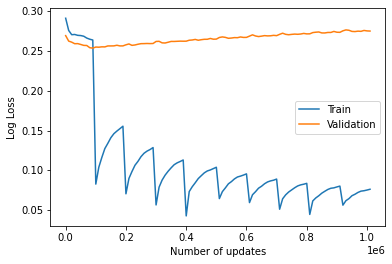

In [ ]:
#Produce a plot of the losses
#ANSWER
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
#figure(figsize=(4, 3), dpi=150) #Colab does only support inline display but you can change figure size with this

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show()
# overfitting, the bumps on the training loss are due to the reset after each epoch. => Not so good to reset the estimation of the loss  
#Log loss is ploted NCE is fine too (anyway this is only a rescaling)

5. Modify the code to enable the use of all quadratic features. This is doable only by modifying the function ```get_x``` 


In [ ]:
#ANSWER with ony one vector for parameters. This is also possible to split the first and second order terms
def get_x(csv_row, D):
     x = []
     # normal features
     for key, value in csv_row.items():
         index = int(value + key[4:], 16) % D  
         x.append(index)
     # second order terms
     L = len(x)
     for i in range(L):
         for j in range(i+1, L):
             index = (x[i] * x[j]) % D  # second weakest hash
             x.append(index)

     # bias
     x.append(0)

     return x

4. After how many updates are you overfitting ? Same question after adding a L2 regularisation term with ponderation $5\cdot 10^{-4}$ and/or with a the learning rate of 0.01. (side question should we include the bias term in the regularization ?)



In [ ]:
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] #To stores our training losses after each 10k updates 
validation_losses = [] #Same for validation

for e in range(n_epochs):
  training_loss = 0 #We reset to 0 the training at the begginning of each epoch to have a better idea of the current performance on the training set
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_w(w, n, x, p, target)
      n_updates += 1

2021-10-25 08:26:21.832006	updates: 10000	current logloss on train: 0.291079	current logloss on validation: 0.269238 	NCE in validation 0.168801
2021-10-25 08:26:25.201032	updates: 20000	current logloss on train: 0.275756	current logloss on validation: 0.262381 	NCE in validation 0.189969
2021-10-25 08:26:28.832710	updates: 30000	current logloss on train: 0.270412	current logloss on validation: 0.261039 	NCE in validation 0.194110
2021-10-25 08:26:32.429669	updates: 40000	current logloss on train: 0.270709	current logloss on validation: 0.259100 	NCE in validation 0.200096
2021-10-25 08:26:35.977303	updates: 50000	current logloss on train: 0.269615	current logloss on validation: 0.259220 	NCE in validation 0.199727
2021-10-25 08:26:39.541006	updates: 60000	current logloss on train: 0.269340	current logloss on validation: 0.258151 	NCE in validation 0.203027
2021-10-25 08:26:43.296101	updates: 70000	current logloss on train: 0.268499	current logloss on validation: 0.256990 	NCE in valid

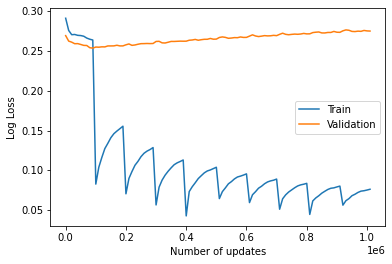

In [ ]:
#Produce a plot of the losses
#ANSWER
x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show()
#Clear overfitting.
#L2 regularization should help. Smaller step size will help in terms of number of updates but is possibly just slowing the process

2021-10-25 09:02:15.642094	updates: 10000	current logloss on train: 0.281488	current logloss on validation: 0.263892 	NCE in validation 0.185305
2021-10-25 09:02:19.573569	updates: 20000	current logloss on train: 0.265193	current logloss on validation: 0.257656 	NCE in validation 0.204554
2021-10-25 09:02:23.647692	updates: 30000	current logloss on train: 0.259603	current logloss on validation: 0.254836 	NCE in validation 0.213263
2021-10-25 09:02:27.869834	updates: 40000	current logloss on train: 0.260076	current logloss on validation: 0.252578 	NCE in validation 0.220233
2021-10-25 09:02:32.076605	updates: 50000	current logloss on train: 0.259459	current logloss on validation: 0.251705 	NCE in validation 0.222928
2021-10-25 09:02:36.124112	updates: 60000	current logloss on train: 0.259321	current logloss on validation: 0.250600 	NCE in validation 0.226338
2021-10-25 09:02:40.171980	updates: 70000	current logloss on train: 0.258817	current logloss on validation: 0.249789 	NCE in valid

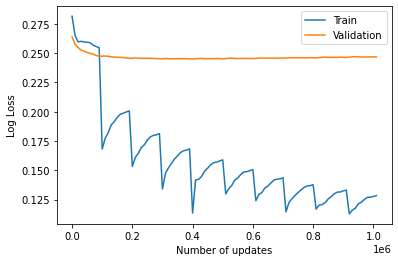

In [ ]:
#ANSWER - same stuff with a L2 regularizer (bias term + quad terms)
#A lot of settings allows a large difference between train and validation, theses are indeed bad
#Remark than combining L1 and L2 is easy and is often named "elasticnet"
import matplotlib.pyplot as plt
import math

def update_wL2(w, n, x, p, y, lbd=5e-4):
    for i in x:
        # L2 reg added here. 
        w[i] -= ((p - y + lbd * 2 * w[i])  ) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

sign = lambda x: math.copysign(1, x) #python has cumbersome sign function 
def update_wL1(w, n, x, p, y, lbd=5e-4):
    for i in x:
        w[i] -= ((p - y) * 2 + lbd * sign(w[i])) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

D = 2 ** 24
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] 
validation_losses = [] 
alpha = .01 #CARE THE LEARNING RATE HAS BEEN MODIFIED 

for e in range(n_epochs):
  training_loss = 0
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_wL2(w, n, x, p, target) #CODE UPDATED HERE 
      n_updates += 1

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show() 

wL2 = w #keep it for later use

#Depending on the learning rate and the coefficent in front of regularization this is possible 
#to have some overfitting advocating for early stopping. Remark that it does not hurt as hard the validation performance 
#Gains remains quite unclear, possibly due to the small dataset size   

2021-10-25 09:09:05.760722	updates: 10000	current logloss on train: 0.281551	current logloss on validation: 0.263981 	NCE in validation 0.185028
2021-10-25 09:09:09.901926	updates: 20000	current logloss on train: 0.265263	current logloss on validation: 0.257711 	NCE in validation 0.204385
2021-10-25 09:09:13.960799	updates: 30000	current logloss on train: 0.259670	current logloss on validation: 0.254891 	NCE in validation 0.213091
2021-10-25 09:09:18.031773	updates: 40000	current logloss on train: 0.260147	current logloss on validation: 0.252651 	NCE in validation 0.220007
2021-10-25 09:09:22.137741	updates: 50000	current logloss on train: 0.259528	current logloss on validation: 0.251794 	NCE in validation 0.222654
2021-10-25 09:09:26.183138	updates: 60000	current logloss on train: 0.259385	current logloss on validation: 0.250691 	NCE in validation 0.226059
2021-10-25 09:09:30.320691	updates: 70000	current logloss on train: 0.258885	current logloss on validation: 0.249883 	NCE in valid

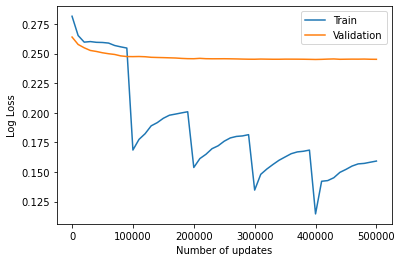

In [ ]:
#Restart the main loop. This does not look as an optimal strategy. 
D = 2 ** 24
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 5
n_updates = 0
training_losses = [] 
validation_losses = [] 
alpha = .01 

for e in range(n_epochs):
  training_loss = 0
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_wL1(w, n, x, p, target) #CODE UPDATED HERE 
      n_updates += 1

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show() 

wL1 = w #keep it for later use


6. Plot an histogram of the values of the parameters without any regularization, with a L1 regularization and with a L2 one. If there is too many values in w you can subsample it. Can you explain the plots?



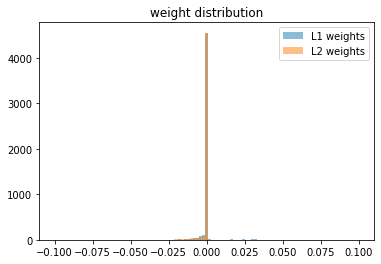

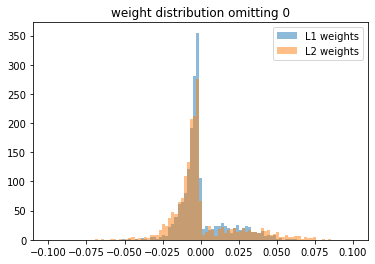

In [ ]:
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(wL1[:5000], bins, alpha=0.5, label='L1 weights')
plt.hist(wL2[:5000], bins, alpha=0.5, label='L2 weights')
plt.legend(loc='upper right')
plt.title('weight distribution')
plt.show()

#Indeed there is many zeros in the array (even more for L1 which is expected as it induces sparcity). 
#To have a resonnable plot we can remove them by
wL1_np = np.array(wL1)
wL2_np = np.array(wL2)
wL1_np[wL1_np==0]=np.nan
wL2_np[wL2_np==0]=np.nan
plt.hist(wL1_np[:20000], bins, alpha=0.5, label='L1 weights')
plt.hist(wL2_np[:20000], bins, alpha=0.5, label='L2 weights')
plt.legend(loc='upper right')
plt.title('weight distribution omitting 0')
plt.show()
#We observe a lot of small values for parameters which is typical of a large scale log reg with quad features and make them hard to interpret. 


8. Optimize the hyperparameters (the $L_1/L_2$ terms and the step size of the descent). Maybe this is time to use an external tool such as [Weight and Biases](https://wandb.ai/site) (the easy free for personal use path). It is possible to achieve the same results with  [Ray-Tune](https://docs.ray.io/en/latest/tune/index.html) combined with [MLflow](https://mlflow.org/) (the open source way).

Some documentation on hyperparamter tuning [here](https://docs.wandb.ai/guides/sweeps/python-api)

In [ ]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 139 kB 53.8 MB/s 
     |████████████████████████████████| 180 kB 42.0 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=d41b7fdbd6906809b51c35da6454e89469f123db5244501883db25081bcc6198
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=145379c19c03a004a03625ae40c3108630546be0dc389826b4f7710061d455dc
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wan

In [ ]:
import wandb
#Note that is exist the possiblity to create such config in a yaml file more info at https://docs.wandb.ai/guides/track/config
#This may be used to store the results of experiments (including models) in a common place
#Here we are going to create to config automatically thanks to a sweep but this is not the sole usage

sweep_config = {
  "name" : "TP1-ENSAE-hyperparameter_search",
  "method" : "random", #There exist several strategies such as Bayes and it possible to add some early stopping (see Hyperband). Care NCE is not a loss (higher is better)
  "parameters" : {
    "epochs" : {
      "values" : [1, 5, 10]
    },
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    },
    "l1":{
      "min": 0.,
      "max": 0.1
    },
    "l2":{
      "min": 0.,
      "max": 0.1
    },
  }
}
sweep_id = wandb.sweep(sweep_config)


Create sweep with ID: 3vgytvlh
Sweep URL: https://wandb.ai/jmary/uncategorized/sweeps/3vgytvlh


In [ ]:
def update_w_elastic(w, n, x, p, y, l1, l2, alpha):
    for i in x:
        w[i] -= (p - y + 2 * l2 * w[i] + l1*sign(w[i]) ) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

def train():
  with wandb.init(reinit=True) as run:
    config = wandb.config
    D = 2 ** 24
    w = [0.] * D  
    n = [0.] * D
    loss = 0.
    n_updates = 0

    for e in range(config['epochs']):
      for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
          x = get_x(row, D)
          p = get_p(x, w)
          target = float(y['click'])
          if n_updates% 10000 == 0 and n_updates>1:
              wandb.log({"loss": compute_validation_loss(w, D),
                         "epoch": e,
                         "n_updates":n_updates})
          w, n = update_w_elastic(w, n, x, p, target, config['l1'], config['l2'], config['learning_rate'])  
          n_updates += 1

count = 10 #Indeed the more the better and longer
#Using the same sweep_id it is also possible to distribute the training
wandb.agent(sweep_id, function=train, count=count) 

wandb: Agent Starting Run: jn4fo0q7 with config:
wandb: 	epochs: 5
wandb: 	l1: 0.04124553925054069
wandb: 	l2: 0.03778997831617628
wandb: 	learning_rate: 0.019793832082334397


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
loss,█▅▄▃▃▃▂▁▁▁▁▂▂▂▁▂▁▁▂▂▂▂▁▂▁▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂
n_updates,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,4
loss,0.2536
n_updates,510000


wandb: Agent Starting Run: a3inqsvo with config:
wandb: 	epochs: 1
wandb: 	l1: 0.07929978195556381
wandb: 	l2: 0.04412435222093099
wandb: 	learning_rate: 0.053911402664362965


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▄▆▂▄▃▃▃▁▂
n_updates,▁▂▃▃▄▅▆▆▇█
epoch,0
loss,0.26863
n_updates,100000


wandb: Agent Starting Run: x2796rnu with config:
wandb: 	epochs: 10
wandb: 	l1: 0.08430106475208746
wandb: 	l2: 0.06851354320718617
wandb: 	learning_rate: 0.050213592155775616


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▆▄▃▁▂▄▄▃▄▅▄▂▄▆▄▄▅▅▄▄▅▅▅▄▅▆▅▄▆▆▆▆▆▆▆▅▆▇▇
n_updates,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,9
loss,0.2758
n_updates,1020000


wandb: Agent Starting Run: fboptou0 with config:
wandb: 	epochs: 1
wandb: 	l1: 0.02796910008987924
wandb: 	l2: 0.049851805400657125
wandb: 	learning_rate: 0.0848513028228197


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▅▆▄▄▃▃▃▁▁
n_updates,▁▂▃▃▄▅▆▆▇█
epoch,0
loss,0.27522
n_updates,100000


wandb: Agent Starting Run: h238mjf8 with config:
wandb: 	epochs: 10
wandb: 	l1: 0.0019979418921936445
wandb: 	l2: 0.01057399337838092
wandb: 	learning_rate: 0.0059667201550245704


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_updates,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,9
loss,0.24509
n_updates,1020000


wandb: Agent Starting Run: ijzukhnb with config:
wandb: 	epochs: 1
wandb: 	l1: 0.057264555565892855
wandb: 	l2: 0.012009484432108732
wandb: 	learning_rate: 0.08196300614131087


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▅▇▃▄▃▃▃▁▂
n_updates,▁▂▃▃▄▅▆▆▇█
epoch,0
loss,0.2754
n_updates,100000


wandb: Agent Starting Run: jv56w8z4 with config:
wandb: 	epochs: 10
wandb: 	l1: 0.09806597131980686
wandb: 	l2: 0.06977660096731027
wandb: 	learning_rate: 0.07007478968823229


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,██▄▄▁▂▃▄▃▄▄▃▂▄▅▄▄▄▅▄▄▅▅▄▃▅▆▅▄▅▆▅▅▅▆▅▄▆▇▆
n_updates,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,9
loss,0.28545
n_updates,1020000


wandb: Agent Starting Run: hee1eyxk with config:
wandb: 	epochs: 1
wandb: 	l1: 0.09882516605873105
wandb: 	l2: 0.00754720243584941
wandb: 	learning_rate: 0.0879750445449675


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▅█▂▃▄▃▄▁▂
n_updates,▁▂▃▃▄▅▆▆▇█
epoch,0
loss,0.28497
n_updates,100000


wandb: Agent Starting Run: cddv7maw with config:
wandb: 	epochs: 5
wandb: 	l1: 0.08785869399575895
wandb: 	l2: 0.02253203626493664
wandb: 	learning_rate: 0.021518680418789272


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
loss,█▄▄▂▃▃▂▁▁▁▁▃▃▃▂▃▂▁▂▂▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▂▃▃▂▂
n_updates,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,4
loss,0.2669
n_updates,510000


wandb: Agent Starting Run: xv3dx82m with config:
wandb: 	epochs: 1
wandb: 	l1: 0.09898482402392808
wandb: 	l2: 0.07426023334859248
wandb: 	learning_rate: 0.0581422786640352


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▄▇▂▄▄▄▃▁▂
n_updates,▁▂▃▃▄▅▆▆▇█
epoch,0
loss,0.27531
n_updates,100000


9. Pick one or more kind of gradient descent in [this page ](https://ruder.io/optimizing-gradient-descent/index.html) and implement it (AdaGrad / Adam / [Nesterov's acceleration](https://jlmelville.github.io/mize/nesterov.html) / [SAGA](https://arxiv.org/pdf/1407.0202.pdf) are popular choices). Remark than even an averaged gradient descent will double the memory consuption and significantly increase the execution times in Python. 

In [ ]:
#Let's go for Adam
#Unchecked code, just the minimal elements to insert at the right place in the code

#Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
alpha = 1e-2

def compute_gradient(p, y):
    #Easy to add L1/L2 penalizations if wanted
    return (p - y)

def update_w_adam(w, m, v, x, p, y):
    g = compute_gradient(p, y)
    for i in x:
        m[i] = beta1*m[i] + (1-beta1) * g
        v[i] = beta2*v[i] + (1-beta2) * g**2
        w[i] -= alpha/(sqrt(v[i])+epsilon) * m[i] 
    return w, m, v

#And in the main code include
m = [0.] * D
v = [0.] * D

w, m, v = update_w_adam(w, m, v, x, p, target) 


9. A possibility for relatively small datasets is to create a pipeline using sklearn a minimal implementation. Compare the results with the hand coded solution.  

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

X_train = np.loadtxt('X_train.csv', skiprows=1, delimiter=',')
X_train = [[('%s' % _, 1) for _ in x] for x in X_train]
y_train = np.loadtxt('y_train.csv', skiprows=1, delimiter=',').astype(np.int8)
y_train = y_train[:, 0] #select click data only

X_valid = np.loadtxt('X_valid.csv', skiprows=1, delimiter=',')
X_valid = [[('%s' % _, 1) for _ in x] for x in X_valid]
y_valid = np.loadtxt('y_valid.csv', skiprows=1, delimiter=',').astype(np.int8)
y_valid = y_valid[:, 0] 


# learn model
model = make_pipeline(FeatureHasher(n_features=2*6, input_type='pair'), 
                        PolynomialFeatures(2, interaction_only=False, include_bias=True),
                        #LogisticRegressionCV(n_jobs=4, Cs=10, solver='liblinear') #If you want to cross validate the regularization on train
                        LogisticRegression(solver='liblinear') #If you want a simple logistic regression
      )
model.fit(X_train, y_train)

#compute score in validation
y_hat_valid = model.predict_proba(X_valid)[:,1] #Output of logistic has as many columns than possible classes
print( f'Log loss on validation: {log_loss(y_valid, y_hat_valid)}') #CARE: the option "normalize" for log loss is not the NCE

KeyboardInterrupt: ignored

Not that bad for some basic Python and SGD *versus* C++ code and a second order method. 

(optional since it can require long exe time) Can you recover the performance we had by optimizing hyperparameters? 

#Part II. Graded.

**Due date december 1st**
You can also send your answers to the optional questions 

1. Based on the minimal code example with validation and $L_2$ prenality, implement your own version of a factorization machine. As we do want to use fields this is the same than a rank k asumption on the matrix of the second order terms which can be expressed as $<v_i, v_j>$ with $v_i \in \mathbb{R}^k$ .  Remind that 
$$
\frac{\partial}{\partial \theta} \hat{y}(\mathbf{x})= \begin{cases}1, & \text { if } \theta \text { is } \mbox{the bias term } \omega_0 \\ x_{i}, & \text { if } \theta \text { is } w_{i} \mbox{ (first order term)} \\ x_{i} \sum_{j=1}^{n} v_{j, f} x_{j}-v_{i, f} x_{i}^{2}, & \text { if } \theta \text { is the } i,f \mbox { second order term } <v_i,v_f>   \end{cases}
$$

One possibility to code it is to isolate the second order term within a second vector of parameters while performing the ```get_x``` and change the way the gradient is computed in the ```update_x``` function. Details about factorization machines are in the [original paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf).


2. Optimize the hyperparameters of a factorization machine for several dataset sizes and plot the resulting curve -- use the data contained in the test file to explore bigger than 100k training data size. For this question you can use a library such as [libFM](https://libfm.org). Remind that we already used the 10k first lines of the test data to build our validation set.


In [ ]:
import numpy as np
X_train = np.loadtxt('X_train.csv', skiprows=1, delimiter=',')
X_train = [[('%s' % _, 1) for _ in x] for x in X_train] #Data format expected by the Feature Hasher is a sequence of key,value


In [ ]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import copy

# parameters #################################################################

X_train = 'X_train.csv'  # path to training files
y_train = 'y_train.csv'


D = 2 ** 20   # max number of weights to use (hash size)
alpha = .01    # learning rate for sgd optimization


# function definitions #######################################################

# A. Bounded logloss
# INPUT:
#     p: our prediction
#     y: real answer
# OUTPUT
#     logarithmic loss of p given y
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)


# B. Apply hash trick of the original csv row
# for simplicity, we treat both integer and categorical features as categorical
# INPUT:
#     csv_row: a csv dictionary, ex: {'hash_1': '357', 'hash_2': '', ...}
#     D: the max index that we can hash to
# OUTPUT:
#     x: a list of indices that its value is 1
def get_x(csv_row, D):
    x1 = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D 
        x1.append(index)
    
    # second order terms
    L = len(x1)
    x2 = []
    for i in range(L):
        for j in range(i+1, L):
            index = (x1[i] * x1[j]) % D  # second weakest hash
            x2.append(index)
    return x1,x2


# C. Get probability estimation on x
# INPUT:
#     x: features
#     w: weights
# OUTPUT:
#     probability of p(y = 1 | x; w)
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


# D. Update given model
# INPUT:
#     w: weights
#     n: a counter that counts the number of times we encounter a feature
#        this is used for adaptive learning rate
#     x: feature
#     p: prediction of our model
#     y: answer
# OUTPUT:
#     w: updated model
#     n: updated count
def update_w(w, n, x, p, y):
    x1,x2 = x
    for i in x1:
        # alpha / (sqrt(n) + 1) is the adaptive learning rate heuristic
        # (p - y) * x[i] is the current gradient
        # note that in our case, if i in x then x[i] = 1

        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
    # sum(v[j,f])

    L = len(x1)

    for i in x1:
        for f in range(i+1,L):
            temp_i_f = 0.
            for j in range(0,L):
                if j!=f:
                    temp_i_f+= w[(x1[f] * x1[j]) % D]
            
            i_f = (x1[i] * x1[f]) % D
            w[i_f] -= (p - y) *(1.*temp_i_f-w[i_f]) *alpha / (sqrt(n[i]) + 1.)

    n[i] += 1.
    return w, n



In [ ]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt

X_train = 'X_train.csv'  # path to training files
y_train = 'y_train.csv'


X_valid = 'X_valid.csv'
y_valid = 'y_valid.csv'

w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] #To stores our training losses after each 10k updates 
validation_losses = [] #Same for validation


def compute_validation_loss(w, D):
    ### TODO Complete this function ###
    #ANSWER
    val_loss = 0 
    for t, (row, y)  in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
        x1, x2 = get_x(row, D)
        x_extend = copy.deepcopy(x1)
        x_extend.extend(x2)
        p = get_p(x_extend, w)
        target = float(y['click'])
        val_loss += logloss(p, target)
    return val_loss/t


for e in range(n_epochs):
    training_loss = 0 #We reset to 0 the training at the begginning of each epoch to have a better idea of the current performance on the training set
    for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
        x1, x2 = get_x(row, D)
        x_extend = copy.deepcopy(x1)
        x_extend.extend(x2)
        p = get_p(x_extend, w)
        target = float(y['click'])
        training_loss += logloss(p, target)
        if n_updates% 10000 == 0 and n_updates>1:
            training_losses.append( training_loss/t )
            validation_losses.append( compute_validation_loss(w, D) )
            print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
                  datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
        w, n = update_w(w, n,(x1,x2), p, target)
        n_updates += 1

2022-01-07 21:04:44.811206	updates: 10000	current logloss on train: 0.291513	current logloss on validation: 0.269876 	NCE in validation 0.166831
2022-01-07 21:04:46.968054	updates: 20000	current logloss on train: 0.271724	current logloss on validation: 0.262507 	NCE in validation 0.189581
2022-01-07 21:04:49.145396	updates: 30000	current logloss on train: 0.265001	current logloss on validation: 0.259807 	NCE in validation 0.197916
2022-01-07 21:04:51.330893	updates: 40000	current logloss on train: 0.265395	current logloss on validation: 0.258535 	NCE in validation 0.201842
2022-01-07 21:04:53.502637	updates: 50000	current logloss on train: 0.264715	current logloss on validation: 0.256530 	NCE in validation 0.208033
2022-01-07 21:04:55.678118	updates: 60000	current logloss on train: 0.264471	current logloss on validation: 0.255329 	NCE in validation 0.211740
2022-01-07 21:04:57.834595	updates: 70000	current logloss on train: 0.263899	current logloss on validation: 0.254798 	NCE in valid

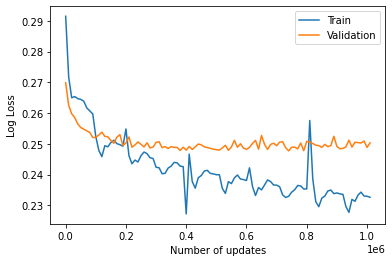

In [ ]:
import matplotlib.pyplot as plt
import math
x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show() 